In [11]:
import os
from collections import Counter
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
import pickle
from PIL import Image
import scipy.io
from torchvision.transforms.functional import equalize


In [12]:
BASE_DIR = './images.tar'  
ANNOTATION_DIR = './annotation.tar'
file_list = scipy.io.loadmat('./file_list.mat')['file_list']
train_list = [str(item[0]) for item in scipy.io.loadmat('./train_list.mat')['file_list']]
test_list = [str(item[0]) for item in scipy.io.loadmat('./test_list.mat')['file_list']]
print(f"Train list: {train_list[:5]} (Total: {len(train_list)})")
print(f"Test list: {test_list[:5]} (Total: {len(test_list)})")
if not os.path.exists("./Images"):
    import tarfile
    with tarfile.open(BASE_DIR, 'r') as tar:
        tar.extractall()
    with tarfile.open(ANNOTATION_DIR, 'r') as tar:
        tar.extractall()
DATASET_DIR = './Images'

BATCH_SIZE = 32

Train list: ["['n02085620-Chihuahua/n02085620_5927.jpg']", "['n02085620-Chihuahua/n02085620_4441.jpg']", "['n02085620-Chihuahua/n02085620_1502.jpg']", "['n02085620-Chihuahua/n02085620_1916.jpg']", "['n02085620-Chihuahua/n02085620_13151.jpg']"] (Total: 12000)
Test list: ["['n02085620-Chihuahua/n02085620_2650.jpg']", "['n02085620-Chihuahua/n02085620_4919.jpg']", "['n02085620-Chihuahua/n02085620_1765.jpg']", "['n02085620-Chihuahua/n02085620_3006.jpg']", "['n02085620-Chihuahua/n02085620_1492.jpg']"] (Total: 8580)


In [13]:
class EqualizeTransform:
    def __call__(self, img):
        return equalize(img)

In [14]:
class WhiteningTransform:
    def __call__(self, tensor):
        return (tensor - tensor.mean()) / (tensor.std() + 1e-8)


In [15]:
def clean_and_normalize_paths(dataset_dir, file_list):
    return [
        os.path.normpath(os.path.join(dataset_dir, path.strip("[]'")).lstrip("./"))
        for path in file_list
    ]

def preprocess_data(
    dataset_path,
    train_list, 
    test_list,
    batch_size=32,
    model_type="default",
    apply_whitening=False,
    apply_equalization=False,
    augment=False
):
    """
    Preprocess images with specific techniques and apply data augmentation.

    Args:
    - dataset_path (str): Path to the dataset folder.
    - train_list (list): List of file paths for training data.
    - test_list (list): List of file paths for testing data.
    - batch_size (int): Size of mini-batches for DataLoader.
    - model_type (str): The type of model for specific preprocessing ("default", "resnet18", "efficientnet").
    - apply_whitening (bool): Whether to apply whitening to the images.
    - apply_equalization (bool): Whether to apply histogram equalization to the images.
    - augment (bool): Whether to apply data augmentation techniques.

    Returns:
    - train_loader, test_loader, eval_loader, classes
    """
    print("Starting preprocessing and augmentation...")
    
    transform_list = [transforms.Resize((224, 224))]

    if augment:
        transform_list.extend([
            transforms.RandomHorizontalFlip(p=0.5), 
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  
        ])

    if apply_equalization:
        transform_list.append(EqualizeTransform())

    transform_list.append(transforms.ToTensor())

    if apply_whitening:
        transform_list.append(WhiteningTransform())

    if model_type == "resnet18":
        transform_list.append(
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        )
    elif model_type == "efficientnet":
        transform_list.append(
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        )
    else:
        temp_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        print("Calculating dataset mean and std...")
        temp_dataset = datasets.ImageFolder(root=dataset_path, transform=temp_transform)
        loader = DataLoader(temp_dataset, batch_size=batch_size, shuffle=False)

        mean = 0.0
        std = 0.0
        for images, _ in loader:
            mean += images.mean([0, 2, 3])
            std += images.std([0, 2, 3])
        mean /= len(loader)
        std /= len(loader)
        print(f"Calculated mean: {mean}, std: {std}")

        transform_list.append(
            transforms.Normalize(mean=mean.tolist(), std=std.tolist())
        )

    transform = transforms.Compose(transform_list)

    print("Loading dataset from:", dataset_path)    
    full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
    train_list = clean_and_normalize_paths(DATASET_DIR, train_list)
    test_list = clean_and_normalize_paths(DATASET_DIR, test_list)
    
    file_paths = {
    os.path.normpath(sample[0]): idx
    for idx, sample in enumerate(full_dataset.samples)
    }

    train_indices = [file_paths.get(path, None) for path in train_list]
    train_indices = [idx for idx in train_indices if idx is not None]

    test_indices = [file_paths.get(path, None) for path in test_list]
    test_indices = [idx for idx in test_indices if idx is not None]
    
    train_dataset = Subset(full_dataset, train_indices)
    test_dataset = Subset(full_dataset, test_indices)

    print(f"Training set size: {len(train_indices)}")
    print(f"Testing set size: {len(test_indices)}")

    print("Creating DataLoaders...")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print("DataLoaders are ready.")
    return train_loader, test_loader, full_dataset.classes

In [16]:
train_loader, _, _ = preprocess_data(DATASET_DIR, train_list, test_list, batch_size=BATCH_SIZE, augment=True, apply_whitening=True, apply_equalization=True)
_, test_loader, classes = preprocess_data(DATASET_DIR, train_list, test_list, batch_size=BATCH_SIZE)


Starting preprocessing and augmentation...
Calculating dataset mean and std...
Calculated mean: tensor([0.4762, 0.4519, 0.3910]), std: tensor([0.2559, 0.2503, 0.2547])
Loading dataset from: ./Images
Training set size: 12000
Testing set size: 8580
Creating DataLoaders...
DataLoaders are ready.
Starting preprocessing and augmentation...
Calculating dataset mean and std...
Calculated mean: tensor([0.4762, 0.4519, 0.3910]), std: tensor([0.2559, 0.2503, 0.2547])
Loading dataset from: ./Images
Training set size: 12000
Testing set size: 8580
Creating DataLoaders...
DataLoaders are ready.


In [17]:
train_no_aug, test_no_aug, classes_no_aug = preprocess_data(DATASET_DIR, train_list, test_list, batch_size=BATCH_SIZE)

Starting preprocessing and augmentation...
Calculating dataset mean and std...
Calculated mean: tensor([0.4762, 0.4519, 0.3910]), std: tensor([0.2559, 0.2503, 0.2547])
Loading dataset from: ./Images
Training set size: 12000
Testing set size: 8580
Creating DataLoaders...
DataLoaders are ready.


In [19]:
print(train_loader.dataset.dataset.transform)


Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    ToTensor()
    Normalize(mean=[0.47615090012550354, 0.45187610387802124, 0.39103034138679504], std=[0.2558988928794861, 0.25031834840774536, 0.2547161877155304])
)


In [20]:
_, test_resnet18, classes_resnet18 = preprocess_data(DATASET_DIR, train_list, test_list, batch_size=BATCH_SIZE, model_type="resnet18")
train_resnet18, _, _ = preprocess_data(DATASET_DIR, train_list, test_list, batch_size=BATCH_SIZE, model_type="resnet18", apply_whitening=True, apply_equalization=True, augment=True)
train_efficientnet, _, _ = preprocess_data(DATASET_DIR, train_list, test_list, batch_size=BATCH_SIZE, model_type="efficientnet", apply_whitening=True, apply_equalization=True, augment=True)
_, test_efficientnet, classes_efficientnet = preprocess_data(DATASET_DIR, train_list, test_list, batch_size=BATCH_SIZE, model_type="efficientnet")

Starting preprocessing and augmentation...
Loading dataset from: ./Images
Training set size: 12000
Testing set size: 8580
Creating DataLoaders...
DataLoaders are ready.
Starting preprocessing and augmentation...
Loading dataset from: ./Images
Training set size: 12000
Testing set size: 8580
Creating DataLoaders...
DataLoaders are ready.
Starting preprocessing and augmentation...
Loading dataset from: ./Images
Training set size: 12000
Testing set size: 8580
Creating DataLoaders...
DataLoaders are ready.
Starting preprocessing and augmentation...
Loading dataset from: ./Images
Training set size: 12000
Testing set size: 8580
Creating DataLoaders...
DataLoaders are ready.


In [21]:
train_resnet_no_augment, test_resnet_no_augment, classes_no_aug = preprocess_data(DATASET_DIR, test_list, train_list, batch_size=BATCH_SIZE, model_type="resnet18")

Starting preprocessing and augmentation...
Loading dataset from: ./Images
Training set size: 8580
Testing set size: 12000
Creating DataLoaders...
DataLoaders are ready.


In [22]:
print("Displaying a batch to verify the DataLoader...")
data_iter = iter(train_loader)
images, labels = next(data_iter)
print(f"Size of an image batch: {images.size()}")
print(f"Size of a label batch: {labels.size()}")

Displaying a batch to verify the DataLoader...
Size of an image batch: torch.Size([32, 3, 224, 224])
Size of a label batch: torch.Size([32])


In [24]:
def plot_class_distribution(data_loader, class_names, title):
    """
    Plot the class distribution for a given DataLoader.
    
    Args:
    - data_loader: The DataLoader from which to extract the data.
    - class_names: List of class names corresponding to the dataset.
    - title: Title of the plot.
    """
    print(f"Plotting class distribution for: {title}")
    

    dataset = data_loader.dataset
    

    if hasattr(dataset, 'dataset') and hasattr(dataset.dataset, 'targets'):
        targets = [dataset.dataset.targets[i] for i in dataset.indices]
    elif hasattr(dataset, 'targets'): 
        targets = dataset.targets
    else:
        raise ValueError("Unable to extract targets from the dataset.")
    

    class_counts = Counter(targets)
    class_labels = [class_names[i] for i in class_counts.keys()]
    class_values = list(class_counts.values())
    

    plt.figure(figsize=(15, 5))
    plt.bar(class_labels, class_values, color='skyblue')
    plt.xticks(rotation=90)
    plt.title(title)
    plt.xlabel("Classes")
    plt.ylabel("Number of Images")
    plt.show()

Plotting class distribution for: Class Distribution in Training Set


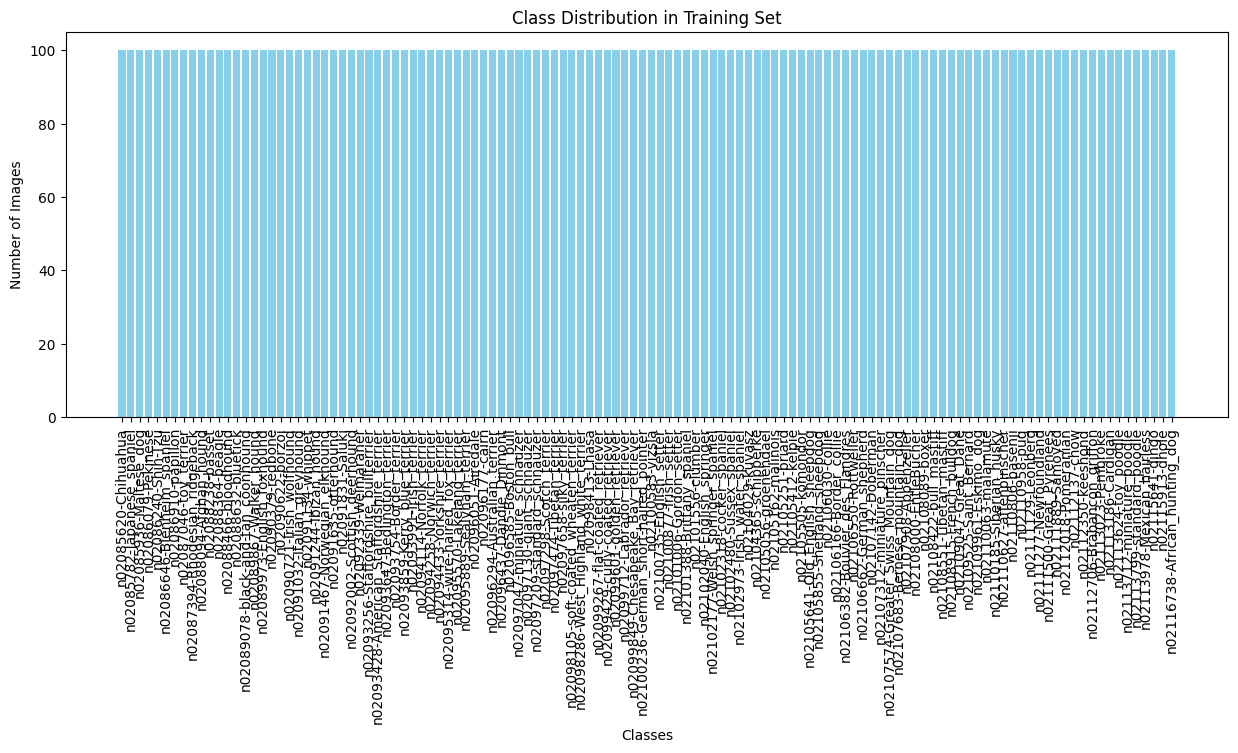

Plotting class distribution for: Class Distribution in Testing Set


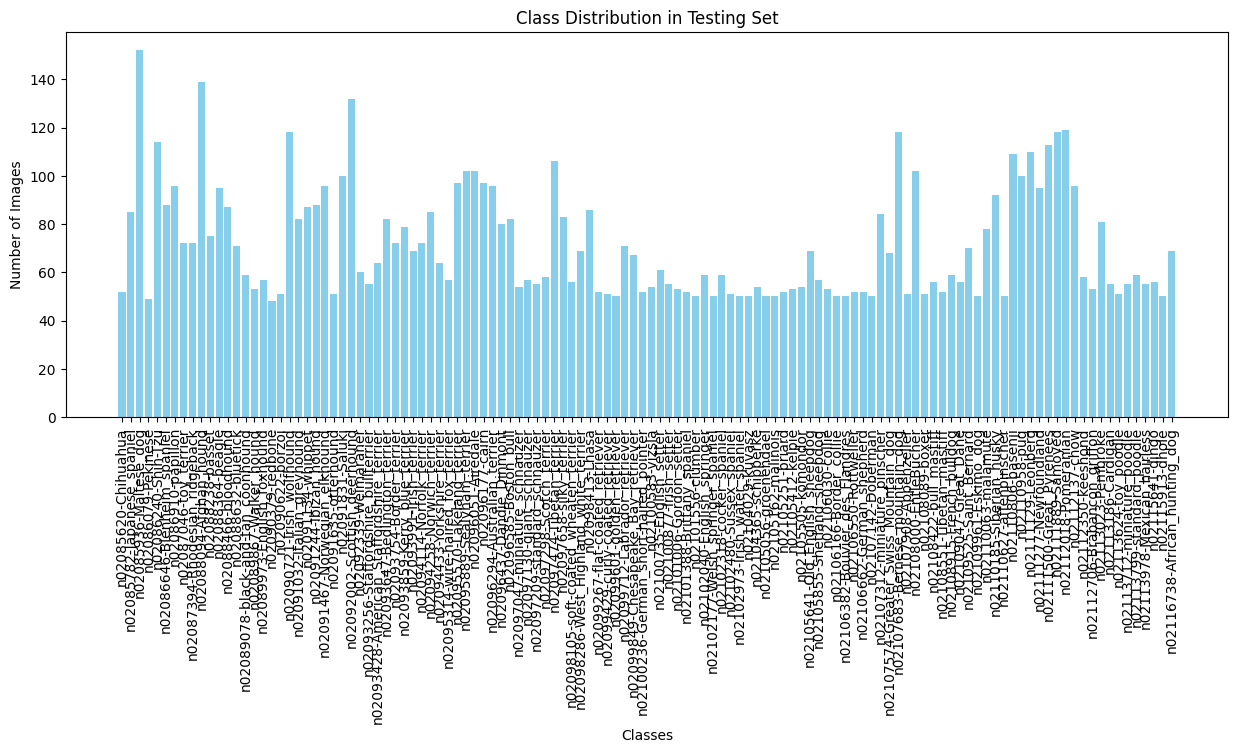

In [25]:
plot_class_distribution(train_loader, classes, "Class Distribution in Training Set")
plot_class_distribution(test_loader, classes, "Class Distribution in Testing Set")

In [27]:
def plot_random_images_from_dataloader(data_loader, class_names, mean, std):
    """
    Plot 5 random images from a DataLoader.

    Args:
    - data_loader: The DataLoader from which to fetch images.
    - class_names: List of class names corresponding to the dataset.
    - mean: Mean used for normalization (list or numpy array).
    - std: Standard deviation used for normalization (list or numpy array).
    """
    
    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    images = images[:5]
    labels = labels[:5]

    plt.figure(figsize=(15, 7))
    for i in range(5):
        img = images[i].permute(1, 2, 0).numpy() 
        img = img * np.array(std) + np.array(mean)
        img = np.clip(img, 0, 1)

        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.title(f"Class: {class_names[labels[i].item()]}")
        plt.axis("off")

    plt.suptitle("Random Images from DataLoader")
    plt.show()

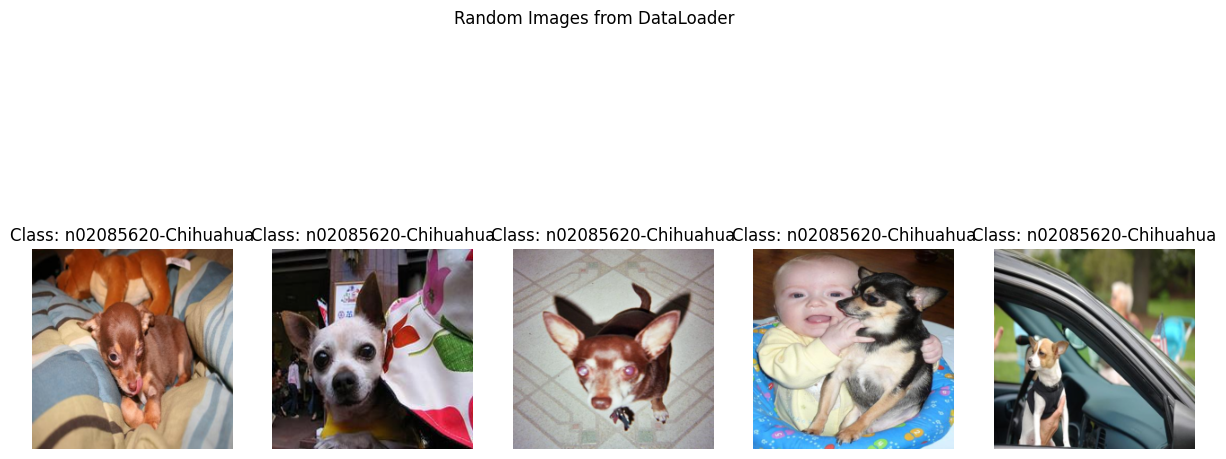

In [28]:
plot_random_images_from_dataloader(test_loader, classes,[0.4762, 0.4519, 0.3910], [0.2559, 0.2503, 0.2547])

In [29]:
save_data = {
    "default": {
        "train_dataset": train_loader.dataset,
        "test_dataset": test_loader.dataset,
        "classes": classes,
        "batch_size": train_loader.batch_size
    },
    "default_no_aug": {
        "train_dataset": train_no_aug.dataset,
        "test_dataset": test_no_aug.dataset,
        "classes": classes_no_aug,
        "batch_size": train_no_aug.batch_size
    },
    "resnet18": {
        "train_dataset": train_resnet18.dataset,
        "test_dataset": test_resnet18.dataset,
        "classes": classes_resnet18,
        "batch_size": train_resnet18.batch_size
    },
    "efficientnet": {
        "train_dataset": train_efficientnet.dataset,
        "test_dataset": test_efficientnet.dataset,
        "classes": classes_efficientnet,
        "batch_size": train_efficientnet.batch_size
    },
    "no_augment": {
        "train_dataset": train_resnet_no_augment.dataset,
        "test_dataset": test_resnet_no_augment.dataset,
        "classes": classes_no_aug,
        "batch_size": train_resnet_no_augment.batch_size
    }
}

with open("datasets_and_classes.pkl", "wb") as f:
    pickle.dump(save_data, f)

print("Datasets and classes (default, ResNet18, EfficientNet) saved successfully!")

Datasets and classes (default, ResNet18, EfficientNet) saved successfully!


In [30]:
print(classes[:20])

['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound']


In [31]:
def save_labels_to_txt(labels, file_path):
    """save labels to a file .txt."""
    with open(file_path, 'w') as file:
        for label in labels:
            file.write(label + ',')

labels = classes
file_path = "./labels.txt"

save_labels_to_txt(labels, file_path)
print(f"labels saved {file_path}.")

labels saved ./labels.txt.
